In [124]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.multiclass import OneVsRestClassifier
import pandas as pd
import numpy as np
from pygam import LogisticGAM, s
from sklearn.metrics import balanced_accuracy_score, accuracy_score
from sklearn.linear_model import LogisticRegression
import scipy
from sklearn.tree import DecisionTreeClassifier





try:
    from pygam import LogisticGAM
except ImportError as e:
    raise ImportError("pyGAM mangler. Kjør: pip install pygam") from e

import pandas as pd

In [125]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from pygam import s, f

In [126]:
class SKLogisticGAM(LogisticGAM):
    def predict_proba(self, X):
        p = super().predict_proba(X)
        if p.ndim == 1:
            return np.vstack([1 - p, p]).T
        return p
    def decision_function(self, X):
        return self._linear_predictor(X)

class SKLogisticGAMBalanced(SKLogisticGAM):
    def fit(self, X, y, **kwargs):
        y = np.asarray(y).astype(int)
        n = y.size
        n_pos = max(1, y.sum())
        n_neg = max(1, n - n_pos)
        w = np.where(y == 1, n / (2.0 * n_pos), n / (2.0 * n_neg))
        return super().fit(X, y, weights=w, **kwargs)


In [127]:
from sklearn.base import BaseEstimator, ClassifierMixin
import numpy as np
from pygam import LogisticGAM, s

class MultiGAMOVR(BaseEstimator, ClassifierMixin):
    def __init__(self, n_splines=14, lam_grid=None, max_iter=40000, tol=1e-4, verbose=False):
        self.n_splines = n_splines
        self.lam_grid = lam_grid if lam_grid is not None else [1e-8,1e-7,1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1.0,10.0,100.0]
        self.max_iter = max_iter
        self.tol = tol
        self.verbose = verbose
        self.classes_ = None
        self.models_ = None
        self.p_ = None

    def _make_terms(self, p):
        terms = s(0, n_splines=self.n_splines)
        for i in range(1, p):
            terms += s(i, n_splines=self.n_splines)
        return terms

    def fit(self, X, y):
        X = np.asarray(X)
        y = np.asarray(y)
        self.classes_ = np.unique(y)
        self.p_ = X.shape[1]
        terms = self._make_terms(self.p_)
        self.models_ = []

        for cls in self.classes_:
            y_bin = (y == cls).astype(int)
            n = y_bin.size
            n_pos = max(1, y_bin.sum())
            n_neg = max(1, n - n_pos)
            w = np.where(y_bin == 1, n/(2.0*n_pos), n/(2.0*n_neg))

            gam = LogisticGAM(terms=terms, max_iter=self.max_iter, tol=self.tol, verbose=self.verbose)
            # robust på tvers av pyGAM-versjoner: ikke send 'progress' som kwarg
            gam.gridsearch(X, y_bin, weights=w, lam=self.lam_grid)
            self.models_.append(gam)
        return self

    def predict_proba(self, X):
        X = np.asarray(X)
        P = np.column_stack([m.predict_proba(X) for m in self.models_])  # (n, K)
        s = P.sum(axis=1, keepdims=True)
        s[s == 0] = 1.0
        return P / s

    def decision_function(self, X):
        X = np.asarray(X)
        return np.column_stack([m._linear_predictor(X) for m in self.models_])

    def predict(self, X):
        P = self.predict_proba(X)
        idx = np.argmax(P, axis=1)
        return self.classes_[idx]


In [128]:
df_my_train_data = pd.read_csv("./student-graduation/processed/train.csv")
df_my_test_data = pd.read_csv("./student-graduation/processed/test.csv")

# df_head = df_my_train_data.head(4000)
#df = df_head.copy()  # eller bruk hele df_my_data i stedet for head(800)
df_train = df_my_train_data.copy()  # eller bruk hele df_my_data i stedet for head(800)
le = LabelEncoder()
df_train['Target'] = le.fit_transform(df_train['Target'])
df_test = df_my_test_data.copy()  # eller bruk hele df_my_data i stedet for head(800)
df_test['Target'] = le.fit_transform(df_test['Target'])

In [129]:


def get_model_and_params(model_type):
    model_type = str(model_type).strip().lower()

    if model_type == "random_forest":
        model = RandomForestClassifier(random_state=42, n_jobs=-1)
        param_grid = {
            'model__n_estimators': [100, 300],
            'model__max_depth': [None, 10, 20],
            'model__min_samples_split': [2, 5]
        }
        print('model = random_forest')
    elif model_type == "svm":
        model = SVC(random_state=42)
        param_grid = {
            'model__C': [0.1, 1, 10],
            'model__kernel': ['linear', 'rbf'],
            'model__gamma': ['scale', 'auto']
        }
        print('model = svm')
    elif model_type in ("neural_net", "mlp"):
        model = MLPClassifier(random_state=42, max_iter=1000, validation_fraction=0.20,n_iter_no_change=20,early_stopping=True, solver='adam',     )
        param_grid = {
            'model__hidden_layer_sizes': [(64,), (128,), (64, 64)],
            'model__alpha': [1e-4, 1e-3, 1e-2],
            'model__learning_rate_init': [1e-3, 1e-2],
            'model__activation': ['relu', 'tanh']
        }
        print('model = neural_net')
    elif model_type == "additive":
        model = MultiGAMOVR()  # lam-grid tunes internt, vi tuner n_splines i sklearn
        param_grid = {"model__n_splines": [8, 14, 20]}
        print('model = additive')

    elif model_type in ("logistic", "logreg", "logistic_regression"):
        model = LogisticRegression(max_iter=2000)
        # Bruk liste av grids for å unngå inkompatible kombinasjoner av solver/penalty
        param_grid = [
            {   # LBFGS: bare L2
                'model__solver': ['lbfgs'],
                'model__penalty': ['l2'],
                'model__C': [0.01, 0.1, 1, 10],
                'model__class_weight': [None, 'balanced']
            },
            {   # liblinear: L1/L2, ovr
                'model__solver': ['liblinear'],
                'model__penalty': ['l1', 'l2'],
                'model__C': [0.01, 0.1, 1, 10],
                'model__class_weight': [None, 'balanced']
            },
            {   # saga: L1/L2, skalerer godt på større datasett
                'model__solver': ['saga'],
                'model__penalty': ['l1', 'l2'],
                'model__C': [0.01, 0.1, 1, 10],
                'model__class_weight': [None, 'balanced']
            }
        ]
    elif model_type == "dt":
        model = DecisionTreeClassifier(random_state=42)
        param_grid = {
            'model__min_samples_leaf': [2, 5],
            "model__min_impurity_decrease": [0.0, 1e-4, 1e-3],
            'model__min_weight_fraction_leaf' :[0.0],
            "model__max_features": [None, "sqrt", "log2"],
            # "model__max_leaf_nodes": [63, 127],
            # 'model__min_samples_split':[2, 5, 10],
            # splitter-strategi
            "model__splitter": ["best", "random"],
            # kostnad-kompleksitets-beskjæring
            "model__ccp_alpha": [0.0, 1e-3,],
            # håndter ev. ubalanse
            "model__class_weight": [None, "balanced"],
            'model__criterion': ['gini', 'entropy', 'log_loss'],
            'model__max_depth': [50,100],
            "model__min_impurity_decrease": [0.0, 1e-4, 1e-3],
        }
        
    else:
        raise ValueError("Ukjent modelltype")
    return model, param_grid

def run_pipeline(data_train: pd.DataFrame, data_test: pd.DataFrame, target_column: str, model_type: str):
    if target_column not in data_train.columns:
        raise ValueError(f"Målkolonnen '{target_column}' finnes ikke i data.")

    X_train = data_train.drop(columns=[target_column])
    y_train = data_train[target_column]

    X_test = data_test.drop(columns=[target_column])
    y_test = data_test[target_column]


    # Konservativ CV basert på minste klassefrekvens
    min_class_count = pd.Series(y_train).value_counts().min()
    cv = int(min(5, max(2, min_class_count)))

    # X_train, X_test, y_train, y_test = train_test_split(
    #     X, y, test_size=0.2, random_state=42, stratify=y
    # )

    model, param_grid = get_model_and_params(model_type)

    if model_type == "additive":
        num_cols = [c for c in X_train.columns if pd.api.types.is_numeric_dtype(X_train[c])]
        if len(num_cols) == 0:
                raise ValueError("Ingen numeriske features tilgjengelig for additive (GAM).")
        preproc = ColumnTransformer(
            transformers=[
                ("num", Pipeline([
                    ("imp", SimpleImputer(strategy="median")),
                ]), num_cols),
            ],
            remainder="drop",
            sparse_threshold=0.0,
            verbose_feature_names_out=False,
        )

        pipeline = Pipeline([
            ("prep", preproc),
            ("model", model),   # MultiGAMOVR
        ])

        # tuner kun n_splines via sklearn; lam tunes internt i hver binær-GAM
        grid_search = GridSearchCV(
            pipeline,
            param_grid,
            cv=cv,
            scoring="balanced_accuracy",
            n_jobs=-1,
            refit=True,
            error_score='raise'
        )

    else:
        # ---- Alle ikke-additive modeller her ----
        steps = [
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler(with_mean=False) if scipy.sparse.issparse(X_train) else StandardScaler()),
            ('model', model)
        ]
        pipeline = Pipeline(steps)
        grid_search = GridSearchCV(
            pipeline,
            param_grid,
            cv=cv,
            scoring='accuracy',
            n_jobs=-1,
            refit=True,
            error_score='raise'
        )

    grid_search.fit(X_train, y_train)

    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)

    print("✅ Beste parametere:", grid_search.best_params_)
    print("📊 Test accuracy:", acc)
    if model_type == "additive":
        y_pred = grid_search.best_estimator_.predict(X_test)
        print("📊 Test accuracy:", accuracy_score(y_test, y_pred))
        print("⚖️ Balanced accuracy:", balanced_accuracy_score(y_test, y_pred))
        best_est = grid_search.best_estimator_
        probs = best_est.predict_proba(X_test)  # shape (n, 3)
        print("Per-klasse proba-mean:", probs.mean(axis=0))
        best_est = grid_search.best_estimator_.named_steps["model"]
        print("Antall under-GAMs:", len(best_est.models_), "p:", best_est.p_)
        print("Coef-norms:", [float(np.linalg.norm(g.coef_)) for g in best_est.models_])
    return best_model



In [130]:
try:
    _ = LogisticGAM  # referanse fra import-cellen
except NameError:
    raise ImportError("pyGAM ikke importert. Kjør import-cellen på nytt eller installer: python -m pip install pygam")

In [131]:
# Mulige modeller å kjøre: "random_forest", "svm", "xgboost", "neural_net, "additive"
#Det må gjøres tuning på additive modellen for få noen resultater, så den er ikke ferdig enda, men de andre modelle fungerer.
model = run_pipeline(df_train, df_test, target_column='Target', model_type='dt')


✅ Beste parametere: {'model__ccp_alpha': 0.0, 'model__class_weight': None, 'model__criterion': 'entropy', 'model__max_depth': 50, 'model__max_features': None, 'model__min_impurity_decrease': 0.0, 'model__min_samples_leaf': 2, 'model__min_weight_fraction_leaf': 0.0, 'model__splitter': 'best'}
📊 Test accuracy: 0.5226039783001808


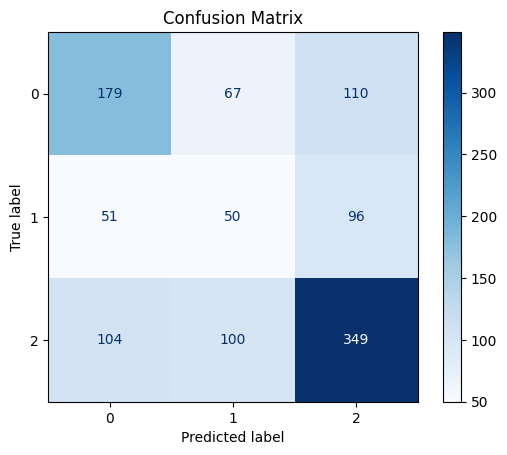

In [135]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics

actual = df_test['Target']
predicted = model.predict(df_test.drop(columns=['Target']))

confusion_matrix = metrics.confusion_matrix(actual, predicted)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix)

disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [133]:
X_train = df_train.drop(columns=['Target'])
y_train = df_train['Target']

X_test = df_test.drop(columns=['Target'])
y_test = df_test['Target']


print(pd.Series(y_train).value_counts(normalize=True))  # ubalanse?
# Baseline: hvor ille er "alltid største klasse"?
major = pd.Series(y_test).value_counts().idxmax()
print("Majoritets-baseline:", (y_test == major).mean())

Target
2    0.333333
1    0.333333
0    0.333333
Name: proportion, dtype: float64
Majoritets-baseline: 0.5


In [134]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

baseline = Pipeline([
    ("imp", SimpleImputer(strategy="median")),
    ("sc", StandardScaler()),
    ("lr", LogisticRegression(max_iter=2000, class_weight="balanced", multi_class="ovr"))
])
baseline.fit(X_train, y_train)
y_pred_bl = baseline.predict(X_test)
from sklearn.metrics import balanced_accuracy_score
print("LR balanced acc:", balanced_accuracy_score(y_test, y_pred_bl))

LR balanced acc: 0.6783264328865499


C:\Users\peder\AppData\Roaming\Python\Python313\site-packages\sklearn\linear_model\_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
